In [4]:
import numpy as np
from netCDF4 import Dataset

import glob 

fs=["simulatedObs_sample.nc"]  # this is a sample of the simulated observations 
                               # results are likely to exhibit some differences relative to the paper
                               # due to the small sample size
xobs=[]
iwc=[]
print(fs)

for f in fs[:]:
    with Dataset(f) as fh:    # read data from netCDF file
        tb_obs=fh["tb"][:,:]
        iwc_SSRG=fh["iwc_SSRG"][:,:]
        zKu=fh["zKu"][:,:]
        pnorm=fh["pnorm"][:,:]

    nt,nchan=tb_obs.shape   
    lidarNoise=np.random.randn(nt,50)*0.1
    pnorm=np.log10(1e-3*(pnorm)*10**lidarNoise+1e-9)  # add noise to lidar backscatter
    pnorm[pnorm<-8.0]=-8.0                            # "zero" out values below the noise floor
    zKu+=np.random.randn(nt,50)*0.5                   # add noise to radar reflectivity  
    tb_obs+=np.random.randn(nt,nchan)*1               # add noise to radiometer brightness temperature
    zKu[zKu<8]=0                                      # "zero" out values below the noise floor

    lidarRadarRadiometerObs=np.concatenate((tb_obs,pnorm,zKu),axis=-1)  # concatenate all observations in one dimension
    iwc.extend(iwc_SSRG)
    xobs.extend(lidarRadarRadiometerObs)


from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

scalerX=StandardScaler()    # define scaler for observations
scalerY=StandardScaler()    # and for the target variable

xobs=np.array(xobs)
iwc=np.array(iwc)
xobs_scaled=scalerX.fit_transform(xobs) # scale the observations
iwc_scaled=scalerY.fit_transform(iwc)   # scale the target variable

nc=18

kmeans=MiniBatchKMeans(n_clusters=nc,random_state=0,batch_size=1024).fit(iwc_scaled)    # cluster the target variable into nc=18 clusters
iwc_cluster=kmeans.labels_

# split the data into training and testing
# import train_test_split from sklearn
from sklearn.model_selection import train_test_split

x_train,x_test,class_train,class_test,iwc_scaled_train,iwc_scaled_test=train_test_split(xobs_scaled,iwc_cluster,iwc_scaled,test_size=0.2,random_state=0)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras import utils

# define the tensorflow classification model
nC=18
def get_model(nC,ninput=xobs_scaled.shape[-1]):
    model = keras.Sequential([
        layers.Dense(30, activation='relu', input_shape=[ninput]),
        layers.Dense(30, activation='relu'),
        layers.Dense(nC, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy())
    return model


model=get_model(nC)
print(model.summary())
# convert to one-hot encoding
y_train_onehot=utils.to_categorical(class_train)
y_test_onehot=utils.to_categorical(class_test)
# standardize the data

# train the model
history = model.fit(x_train[:,:], y_train_onehot,validation_data=(x_test[:,:], y_test_onehot),
    batch_size=32,epochs=20, verbose=1)

model.save('lidarRadarRadiomClassifModel.demo.keras')


['simulatedObs_sample.nc']


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                3330      
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 18)                558       
                                                                 
Total params: 4818 (18.82 KB)
Trainable params: 4818 (18.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
4127/4127 [==============================] - 3s 695us/step - loss: 0.6450 - val_loss: 0.5203
Epoch 2/20
4127/4127 [==============================] - 3s 674us/step - loss: 0.5047 - val_loss: 0.4964
Epoch 3/20
4127/4127 [==============================] - 3s 661us/step -

In [2]:
# estimate the kalman gain for each cluster
iwpC=[]
kgainL=[]
nx=x_train.shape[1]
xobs_m=[]
iwc_m=[]
iwc_train=scalerY.inverse_transform(iwc_scaled_train)  # unscale the target variable
iwc_test=scalerY.inverse_transform(iwc_scaled_test)    # unscale the target variable
iwc_train[iwc_train<0]=0
for i in range(nC):
    a=np.nonzero(class_train==i)
    xk=x_train[a[0],:]
    yk=iwc_train[a[0],:]
    covXY=np.cov(xk.T,yk.T)
    covXX=covXY[:nx,:nx]+0.01*np.eye(nx)
    covYX=covXY[nx:,:nx]
    invCovXX=np.linalg.pinv(covXX)
    kgain=np.dot(covYX,invCovXX)
    kgainL.append(kgain)
    xobs_m.append(np.mean(xk,axis=0))
    iwc_m.append(np.mean(yk,axis=0))

In [3]:
# save the kalman gain and the mean of the observations for each cluster in a pickle file

import pickle
with open('kgainL.demo.pkl','wb') as fh:
    d={"kgainL":kgainL,"xobs_m":xobs_m,"iwc_m":iwc_m,"scalerX":scalerX,"scalerY":scalerY} # include the scalers for the observations and the target variable
    pickle.dump(d,fh)

In [5]:
#predict the iwc for the test data
ninput=x_test.shape[1]
class_onehot_=model.predict(x_test[:,:ninput])
iwc_scaled_retL=[]
for i,iwp1_ in enumerate(x_test[:,-1]):
    iclass=np.argmax(class_onehot_[i,:])
    iwc1=iwc_m[iclass]+np.dot(kgainL[iclass],x_test[i,:]-xobs_m[iclass])
    iwc_scaled_retL.append(iwc1)

iwc_ret=scalerY.inverse_transform(np.array(iwc_scaled_retL))
iwc_ret=iwc_scaled_retL
iwc_test=scalerY.inverse_transform(iwc_scaled_test)

1032/1032 [==============================] - 0s 293us/step


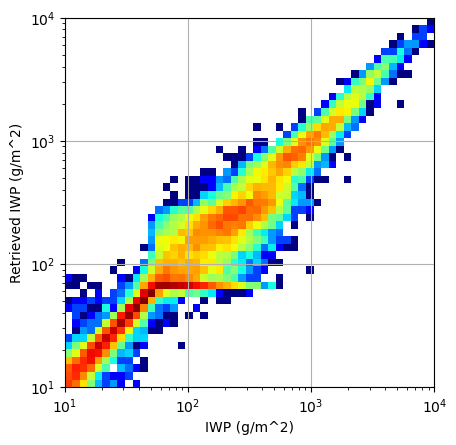

In [6]:
# plot retrieved IWP vs true IWP
import matplotlib.pyplot as plt
import matplotlib
xbins=np.logspace(1,4,50)
plt.figure()
ax=plt.subplot(111)
plt.hist2d(iwc_test.sum(axis=-1)*0.24*1e3,np.array(iwc_ret).sum(axis=-1)*0.24*1e3,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap="jet")
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.xlabel("IWP (g/m^2)")
plt.ylabel("Retrieved IWP (g/m^2)")
plt.grid()